In [1]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# LOAD DATA (UTILS) 

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def load_pickle_files(folder_path):
    env_data = None
    problem_data = []
    solution_data = []

    files = os.listdir(folder_path)

    for file_name in tqdm(files, desc="Loading files"):
        file_path = os.path.join(folder_path, file_name)

        # skip non-files
        if not os.path.isfile(file_path):
            continue

        if file_name == 'env.pickle':
            env_data = load_pickle(file_path)
        elif file_name.startswith('problem_') and file_name.endswith('.pickle'):
            problem_data.append(load_pickle(file_path))
        elif file_name.startswith('solution_') and file_name.endswith('.pickle'):
            solution_data.append(load_pickle(file_path))

    return env_data, problem_data, solution_data

dir = '/Users/jakegonzales/Documents/Amazon/code/mapf/data/train'
folders = os.listdir(dir)

all_env_data = []
all_problem_data = []
all_solution_data = []

for folder in folders:
    folder_path = os.path.join(dir, folder)

    # skip non-directory entries
    if not os.path.isdir(folder_path):
        continue

    # dicts with data 
    env_data, problem_data, solution_data = load_pickle_files(folder_path)
    
    # append data to respective lists
    all_env_data.append(env_data)
    all_problem_data.extend(problem_data)
    all_solution_data.extend(solution_data)


Loading files: 100%|████████████████████████| 5410/5410 [01:34<00:00, 57.49it/s]


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils 

# CREATE CUSTOM DATASET FOR CBS

class CBSDataset(Dataset):
    def __init__(self, env_data, problem_data, solution_data):
        self.env_data = env_data
        self.problem_data = problem_data
        self.solution_data = solution_data

        self.filter_solutions()

    def filter_solutions(self):
        # Filter out problems without solutions
        filtered_problem_data = []
        filtered_solution_data = []

        for problem, solution in zip(self.problem_data, self.solution_data):
            if problem is not None and solution is not None:
                filtered_problem_data.append(problem)
                filtered_solution_data.append(solution)

        self.problem_data = filtered_problem_data
        self.solution_data = filtered_solution_data

    def __len__(self):
        return len(self.problem_data)

    def __getitem__(self, idx):
        problem = self.problem_data[idx]
        solution = self.solution_data[idx]

        #print("SOLUTION \n\n", solution['edges'])

        start_positions = []
        destinations = []
        paths = []

        # FROM PROBLEM
        start_pos_dict = problem['start_pos']
        start_positions = torch.tensor([list(value) for value in start_pos_dict.values()], dtype=torch.float32)
        final_goals_dict = problem['final_goals']
        destinations = torch.tensor([list(value) for value in final_goals_dict.values()], dtype=torch.float32)
        # FROM SOLUTION
        paths_data = solution['paths']

        
        
        return start_positions, destinations

# Create dataset and data loader
dataset = CBSDataset(all_env_data, all_problem_data, all_solution_data)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example usage:
for batch in data_loader:
    start_positions, destinations = batch
    
    # Use these tensors as inputs to your GCN model
    # You can perform further processing or pass them directly to your model


In [3]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# CREATE CUSTOM DATASET FOR GRAPHS

def normalize_adjacency(adj):
    """ Normalizes the adjacency matrix according to the
        paper by Kipf et al.
        https://arxiv.org/pdf/1609.02907.pdf
    """
    adj = adj + sparse.eye(adj.shape[0])

    node_degrees = np.array(adj.sum(1))
    node_degrees = np.power(node_degrees, -0.5).flatten()
    node_degrees[np.isinf(node_degrees)] = 0.0
    node_degrees[np.isnan(node_degrees)] = 0.0
    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)

    adj = degree_matrix @ adj @ degree_matrix
    return adj

def convert_scipy_to_torch_sparse(matrix):
    matrix_helper_coo = matrix.tocoo().astype('float32')
    data = torch.FloatTensor(matrix_helper_coo.data)
    rows = torch.LongTensor(matrix_helper_coo.row)
    cols = torch.LongTensor(matrix_helper_coo.col)
    indices = torch.vstack([rows, cols])

    shape = torch.Size(matrix_helper_coo.shape)
    matrix = torch.sparse.FloatTensor(indices, data, shape)
    return matrix

def to_networkx(env_data): 
    # CREATE NETWORKX GRAPH BASED ON CBS ENV DATA 
    grid_adj = []
    for data in env_data:
        grid_adj.append(data['grid_adj'])
        
    grid_adj = grid_adj[0]

    G = nx.Graph()
    for node, neighbors in grid_adj.items():
        for neighbor in neighbors.keys():
            G.add_edge(node, neighbor)

    # dreate positions for nodes in a 2D grid layout
    pos = {node: node for node in G.nodes()}

    # draw the graph
    #plt.figure(figsize=(16, 16))
    #nx.draw(G, pos, with_labels=True, node_size=100, node_color='lightblue', font_size=10)
    #plt.title("Grid Graph Visualization")
    #plt.show()

    adj_matrix = nx.adjacency_matrix(G)
    adj_matrix = adj_matrix.todense()
    
    
    return adj_matrix

def load_graph_data(env_data):
    # ENV DATA IS FROM CBS
    grid_adj = []
    for data in env_data:
        grid_adj.append(data['grid_adj'])
        
    grid_adj = grid_adj[0]

    # Convert env grid adj to a dense matrix for comparison
    max_i = max(coord[0] for coord in grid_adj.keys())
    max_j = max(coord[1] for coord in grid_adj.keys())
    num_nodes = max(max_i, max_j) + 1 

    # Convert env grid adj to torch sparse adj matrix
    row_indices, col_indices = zip(*[(node[0], neighbor[1]) for node, neighbors in grid_adj.items() for neighbor in neighbors.keys()])
    data = torch.ones(len(row_indices))

    indices = torch.LongTensor([row_indices, col_indices])
    sparse_adj_matrix = torch.sparse_coo_tensor(indices, data, torch.Size([num_nodes, num_nodes]))

    return sparse_adj_matrix


sparse_adj_matrix = load_graph_data(all_env_data)
networkx_adj_matrix = to_networkx(all_env_data)



In [23]:
# BREAK DATA INTO SUBREGION DATA RATHER THAN FULL GRID DATA

# import the CBS data 
env_data = all_env_data
problem_data_uf = all_problem_data
solution_data_uf = all_solution_data

def filter_solutions(problem_data_uf, solution_data_uf):
    
    # Filter out problems without solutions
    filtered_problem_data = []
    filtered_solution_data = []

    for problem, solution in zip(problem_data_uf, solution_data_uf):
        if problem is not None and solution is not None:
            filtered_problem_data.append(problem)
            filtered_solution_data.append(solution)

    problem_data = filtered_problem_data
    solution_data = filtered_solution_data

    return problem_data, solution_data

def divide_subregions(env_data, problem_data, solution_data):
    subregion_nodes = []

    # Extract grid nodes from the first environment data
    grid_nodes = env_data[0]['grid_nodes']

    # Initialize subregion nodes dictionary
    subregion_nodes_dict = {f'subregion_{i}': [] for i in range(1, 26)}

    # Iterate through each grid node
    for node in grid_nodes:
        # Calculate the subregion index based on the node coordinates
        subregion_i = node[0] // 16  # Integer division to get the subregion row
        subregion_j = node[1] // 16  # Integer division to get the subregion column
        subregion_index = subregion_i * 5 + subregion_j  # Convert subregion row and column to index

        # Add the node to the corresponding subregion
        subregion_label = f'subregion_{subregion_index + 1}'  # Subregion label
        subregion_nodes_dict[subregion_label].append(node)

    # Append the subregion nodes dictionary to the list
    subregion_nodes.append(subregion_nodes_dict)

    return subregion_nodes
    

problem_data, solution_data = filter_solutions(problem_data, solution_data)


subregion_nodes = divide_subregions(env_data, problem_data, solution_data)


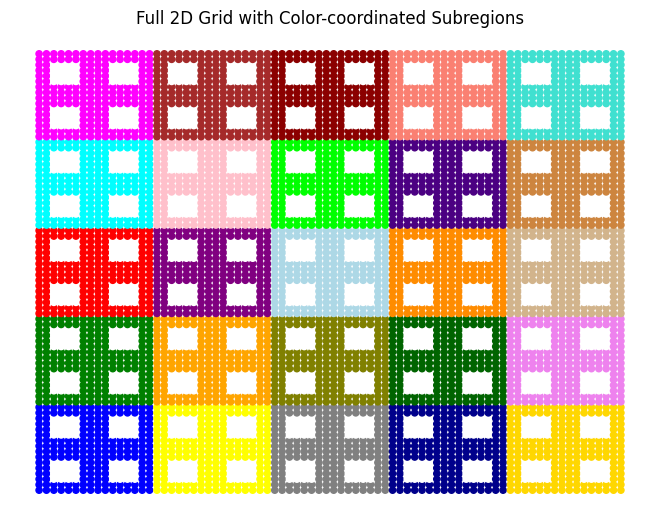

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

## FULL GRID VISUALIZATION WITH SUBREGION COLOR COORDINATION

def plot_subregions(subregion_nodes):

    nrows, ncols = 80, 80
    G = nx.Graph()
    for i in range(nrows):
        for j in range(ncols):
            G.add_node((i, j))

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'pink', 'brown',
              'gray', 'olive', 'lightblue', 'lime', 'darkred', 'darkblue', 'darkgreen', 'darkorange', 'indigo',
              'salmon', 'gold', 'violet', 'tan', 'peru', 'turquoise']

    node_colors = {}
    for subregion, nodes in subregion_nodes[0].items():
        color = colors[int(subregion.split('_')[1]) - 1]
        for node in nodes:
            node_colors[node] = color

    # assign obstacles white
    for node in G.nodes():
        if node not in node_colors:
            node_colors[node] = 'white' 

    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color=[node_colors[node] for node in G.nodes()], with_labels=False, node_size=20)

    plt.title("Full 2D Grid with Color-coordinated Subregions")
    plt.show()

plot_subregions(subregion_nodes)
